In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [2]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
import datetime


In [3]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)


In [4]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [5]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    #x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)


In [9]:
print (pnls)

[[0, array([0.00617791], dtype=float32), -0.00546775, -0.00546775], [1, array([0.00173255], dtype=float32), 0.0234365, 0.0234365], [2, array([-0.00107555], dtype=float32), -0.00078075, 0.00078075], [3, array([0.00076251], dtype=float32), -0.00625, -0.00625], [4, array([-0.0007264], dtype=float32), -0.05, 0.05], [5, array([0.00289931], dtype=float32), 0.001562, 0.001562], [6, array([0.00077582], dtype=float32), -0.01171875, -0.01171875], [7, array([-0.00166608], dtype=float32), 0.009376, -0.009376], [8, array([-0.00210872], dtype=float32), -0.003126, 0.003126], [9, array([0.00040555], dtype=float32), -0.01328075, -0.01328075], [10, array([0.00115814], dtype=float32), 0.0296875, 0.0296875], [11, array([-0.00460203], dtype=float32), 0.009375, -0.009375], [12, array([0.00050185], dtype=float32), -0.0265625, -0.0265625], [13, array([0.00418288], dtype=float32), 0.064062, 0.064062], [14, array([-0.00613332], dtype=float32), -0.02265625, 0.02265625], [15, array([0.0044188], dtype=float32), 0.

In [12]:
SEQUENCE_SIZE   = 10
pnls    = []
pnlsOnly = []
row,col = df.shape
start = datetime.datetime.now()

for x in range(windowsize,row-stepsize,stepsize):
    print("Iteration x = ",x," to row-stepsize ",row-stepsize)
    df_train = df.iloc[x-windowsize:x,:]
    df_test  = df.iloc[x:x+stepsize]
    df = df.loc[:,input_fields]
    spots_train = df_train[target_col].tolist()
    spots_test = df_test[target_col].tolist()
    #spots_train = df.apply(lambda x: x.tolist(), axis=1).tolist()
    #spots_test = df.apply(lambda x: x.tolist(), axis=1).tolist()

#    print("Training set has {} observations.".format(len(spots_train)))
#    print("Test set has {} observations.".format(len(spots_test)))
    x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
    x_test,y_test   = to_sequences(SEQUENCE_SIZE,spots_test)

#    print("Shape of training set: {}".format(x_train.shape))
#    print("Shape of test set: {}".format(x_test.shape))

    input_shape = x_train.shape[1:]
#    print(input_shape)
    
    model = build_model(
        
        input_shape,
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4)
    )

    model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=10, \
        restore_best_weights=True)]

    model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        epochs=10, #200,
        batch_size=64,
        callbacks=callbacks,
    )
    finish = datetime.datetime.now()
    
    model.evaluate(x_test, y_test, verbose=1)



    pred = model.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Score (RMSE): {}".format(score)) 

    total   = 0
    counter = 0

    for x in range(len(pred)):
        if pred[x] > 0.0:
            total = y_test[x]
        elif pred[x] < 0.0:
            total = -1*y_test[x]
            
        pnls.append([x,pred[x],y_test[x],total])
        pnlsOnly.append (total)

    print("time to execute = ",finish-start)
"""
#dfpnl = pd.DataFrame(data = pnls, columns=['cumpnl'])
dfpnl = pd.DataFrame(data = pnlsOnly, columns=['cumpnl'])
dfpnl['pnl'] = dfpnl['cumpnl'] - dfpnl['cumpnl'].shift(1)

dfpnl['cummax'] = dfpnl['cumpnl'].cummax()
ret = dfpnl['pnl'].mean()*252
vol = dfpnl['pnl'].std()*pow(252,0.5)
dfpnl['dd'] = dfpnl['cummax'] - df['cumpnl']
mdd = dfpnl['dd'].max()
print("Return = ",ret)
print("Vol    = ",vol)
info =0
if(vol>0):
    info = ret/vol
print("Info  = ",info)
calmar=0
if (mdd>0):
    calmar = ret/mdd
print("MDD  = ",mdd)
print("Calmar = ",calmar)
df['cumpnl'].plot()
df['cummax'].plot()
"""

Iteration x =  7000  to row-stepsize  7797
Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization_344 (Layer  (None, 10, 1)       2           ['input_44[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_172 (Mult  (None, 10, 1)       7169        ['layer_normalization_344[0][0]',
 iHeadAttention)                                                  'layer_normalization_344[0][0]']
                                                

 Normalization)                                                  ]                                
                                                                                                  
 multi_head_attention_175 (Mult  (None, 10, 1)       7169        ['layer_normalization_350[0][0]',
 iHeadAttention)                                                  'layer_normalization_350[0][0]']
                                                                                                  
 dropout_393 (Dropout)          (None, 10, 1)        0           ['multi_head_attention_175[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_350 (TFOp  (None, 10, 1)       0           ['dropout_393[0][0]',            
 Lambda)                                                          'tf.__operators__.add_349[0][0]'
          

                                                                                                  
 multi_head_attention_177 (Mult  (None, 10, 1)       7169        ['layer_normalization_354[0][0]',
 iHeadAttention)                                                  'layer_normalization_354[0][0]']
                                                                                                  
 dropout_398 (Dropout)          (None, 10, 1)        0           ['multi_head_attention_177[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_354 (TFOp  (None, 10, 1)       0           ['dropout_398[0][0]',            
 Lambda)                                                          'tf.__operators__.add_353[0][0]'
                                                                 ]                                
          

                                                                                                  
 dense_89 (Dense)               (None, 1)            129         ['dropout_404[0][0]']            
                                                                                                  
Total params: 30,281
Trainable params: 30,281
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/10
88/88 [==============================] - 14s 133ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 2/10
88/88 [==============================] - 11s 129ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 3/10
88/88 [==============================] - 11s 128ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 4/10
88/88 [==============================] - 11s 128ms/step - loss: 9.5359e-04 - val_loss: 0.0012
Epoch 5/10
88/88 [==============================] - 11s 129ms/step - loss: 9.8985e-04 - val_loss: 0.0012
Epoch 6/10
88/88 [===

 tf.__operators__.add_364 (TFOp  (None, 10, 1)       0           ['dropout_409[0][0]',            
 Lambda)                                                          'tf.__operators__.add_363[0][0]'
                                                                 ]                                
                                                                                                  
 layer_normalization_365 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_364[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 conv1d_364 (Conv1D)            (None, 10, 4)        8           ['layer_normalization_365[0][0]']
                                                                                                  
 dropout_410 (Dropout)          (None, 10, 4)        0           ['conv1d_364[0][0]']             
          

 tf.__operators__.add_368 (TFOp  (None, 10, 1)       0           ['dropout_414[0][0]',            
 Lambda)                                                          'input_47[0][0]']               
                                                                                                  
 layer_normalization_369 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_368[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 conv1d_368 (Conv1D)            (None, 10, 4)        8           ['layer_normalization_369[0][0]']
                                                                                                  
 dropout_415 (Dropout)          (None, 10, 4)        0           ['conv1d_368[0][0]']             
                                                                                                  
 conv1d_36

                                                                                                  
 conv1d_374 (Conv1D)            (None, 10, 4)        8           ['layer_normalization_375[0][0]']
                                                                                                  
 dropout_421 (Dropout)          (None, 10, 4)        0           ['conv1d_374[0][0]']             
                                                                                                  
 conv1d_375 (Conv1D)            (None, 10, 1)        5           ['dropout_421[0][0]']            
                                                                                                  
 tf.__operators__.add_375 (TFOp  (None, 10, 1)       0           ['conv1d_375[0][0]',             
 Lambda)                                                          'tf.__operators__.add_374[0][0]'
                                                                 ]                                
          

 conv1d_378 (Conv1D)            (None, 10, 4)        8           ['layer_normalization_379[0][0]']
                                                                                                  
 dropout_426 (Dropout)          (None, 10, 4)        0           ['conv1d_378[0][0]']             
                                                                                                  
 conv1d_379 (Conv1D)            (None, 10, 1)        5           ['dropout_426[0][0]']            
                                                                                                  
 tf.__operators__.add_379 (TFOp  (None, 10, 1)       0           ['conv1d_379[0][0]',             
 Lambda)                                                          'tf.__operators__.add_378[0][0]'
                                                                 ]                                
                                                                                                  
 layer_nor

Epoch 9/10
88/88 [==============================] - 10s 117ms/step - loss: 9.4986e-04 - val_loss: 0.0013
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Score (RMSE): 0.027008114546687632
time to execute =  0:09:46.083080
Iteration x =  7250  to row-stepsize  7797
Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization_384 (Layer  (None, 10, 1)       2           ['input_49[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_he

 Lambda)                                                          'tf.__operators__.add_388[0][0]'
                                                                 ]                                
                                                                                                  
 layer_normalization_390 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_389[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 multi_head_attention_195 (Mult  (None, 10, 1)       7169        ['layer_normalization_390[0][0]',
 iHeadAttention)                                                  'layer_normalization_390[0][0]']
                                                                                                  
 dropout_438 (Dropout)          (None, 10, 1)        0           ['multi_head_attention_195[0][0]'
          

                                                                                                  
 layer_normalization_394 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_393[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 multi_head_attention_197 (Mult  (None, 10, 1)       7169        ['layer_normalization_394[0][0]',
 iHeadAttention)                                                  'layer_normalization_394[0][0]']
                                                                                                  
 dropout_443 (Dropout)          (None, 10, 1)        0           ['multi_head_attention_197[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__oper

                                                                 0]']                             
                                                                                                  
 dropout_449 (Dropout)          (None, 128)          0           ['dense_98[0][0]']               
                                                                                                  
 dense_99 (Dense)               (None, 1)            129         ['dropout_449[0][0]']            
                                                                                                  
Total params: 30,281
Trainable params: 30,281
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/10
88/88 [==============================] - 14s 128ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 2/10
88/88 [==============================] - 11s 124ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 3/10
88/88 [=================

 dropout_454 (Dropout)          (None, 10, 1)        0           ['multi_head_attention_202[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_404 (TFOp  (None, 10, 1)       0           ['dropout_454[0][0]',            
 Lambda)                                                          'tf.__operators__.add_403[0][0]'
                                                                 ]                                
                                                                                                  
 layer_normalization_405 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_404[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 conv1d_40

                                                                 ]                                
                                                                                                  
 tf.__operators__.add_408 (TFOp  (None, 10, 1)       0           ['dropout_459[0][0]',            
 Lambda)                                                          'input_52[0][0]']               
                                                                                                  
 layer_normalization_409 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_408[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 conv1d_408 (Conv1D)            (None, 10, 4)        8           ['layer_normalization_409[0][0]']
                                                                                                  
 dropout_4

 layer_normalization_415 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_414[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 conv1d_414 (Conv1D)            (None, 10, 4)        8           ['layer_normalization_415[0][0]']
                                                                                                  
 dropout_466 (Dropout)          (None, 10, 4)        0           ['conv1d_414[0][0]']             
                                                                                                  
 conv1d_415 (Conv1D)            (None, 10, 1)        5           ['dropout_466[0][0]']            
                                                                                                  
 tf.__operators__.add_415 (TFOp  (None, 10, 1)       0           ['conv1d_415[0][0]',             
 Lambda)  

                                                                                                  
 conv1d_418 (Conv1D)            (None, 10, 4)        8           ['layer_normalization_419[0][0]']
                                                                                                  
 dropout_471 (Dropout)          (None, 10, 4)        0           ['conv1d_418[0][0]']             
                                                                                                  
 conv1d_419 (Conv1D)            (None, 10, 1)        5           ['dropout_471[0][0]']            
                                                                                                  
 tf.__operators__.add_419 (TFOp  (None, 10, 1)       0           ['conv1d_419[0][0]',             
 Lambda)                                                          'tf.__operators__.add_418[0][0]'
                                                                 ]                                
          

Epoch 8/10
88/88 [==============================] - 11s 126ms/step - loss: 9.9313e-04 - val_loss: 0.0014
Epoch 9/10
88/88 [==============================] - 11s 126ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Score (RMSE): 0.031372887596273165
time to execute =  0:19:09.630132
Iteration x =  7500  to row-stepsize  7797
Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization_424 (Layer  (None, 10, 1)       2           ['input_54[0][0]']               
 Normalization)                                                                                   
       

 tf.__operators__.add_429 (TFOp  (None, 10, 1)       0           ['conv1d_429[0][0]',             
 Lambda)                                                          'tf.__operators__.add_428[0][0]'
                                                                 ]                                
                                                                                                  
 layer_normalization_430 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_429[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 multi_head_attention_215 (Mult  (None, 10, 1)       7169        ['layer_normalization_430[0][0]',
 iHeadAttention)                                                  'layer_normalization_430[0][0]']
                                                                                                  
 dropout_4

                                                                 ]                                
                                                                                                  
 layer_normalization_434 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_433[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 multi_head_attention_217 (Mult  (None, 10, 1)       7169        ['layer_normalization_434[0][0]',
 iHeadAttention)                                                  'layer_normalization_434[0][0]']
                                                                                                  
 dropout_488 (Dropout)          (None, 10, 1)        0           ['multi_head_attention_217[0][0]'
                                                                 ]                                
          

 dense_108 (Dense)              (None, 128)          1408        ['global_average_pooling1d_54[0][
                                                                 0]']                             
                                                                                                  
 dropout_494 (Dropout)          (None, 128)          0           ['dense_108[0][0]']              
                                                                                                  
 dense_109 (Dense)              (None, 1)            129         ['dropout_494[0][0]']            
                                                                                                  
Total params: 30,281
Trainable params: 30,281
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/10
88/88 [==============================] - 14s 130ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2/10
88/88 [===================

                                                                                                  
 dropout_499 (Dropout)          (None, 10, 1)        0           ['multi_head_attention_222[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_444 (TFOp  (None, 10, 1)       0           ['dropout_499[0][0]',            
 Lambda)                                                          'tf.__operators__.add_443[0][0]'
                                                                 ]                                
                                                                                                  
 layer_normalization_445 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_444[0][0]'
 Normalization)                                                  ]                                
          

 dropout_504 (Dropout)          (None, 10, 1)        0           ['multi_head_attention_224[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_448 (TFOp  (None, 10, 1)       0           ['dropout_504[0][0]',            
 Lambda)                                                          'input_57[0][0]']               
                                                                                                  
 layer_normalization_449 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_448[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 conv1d_448 (Conv1D)            (None, 10, 4)        8           ['layer_normalization_449[0][0]']
          

                                                                                                  
 layer_normalization_455 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_454[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 conv1d_454 (Conv1D)            (None, 10, 4)        8           ['layer_normalization_455[0][0]']
                                                                                                  
 dropout_511 (Dropout)          (None, 10, 4)        0           ['conv1d_454[0][0]']             
                                                                                                  
 conv1d_455 (Conv1D)            (None, 10, 1)        5           ['dropout_511[0][0]']            
                                                                                                  
 tf.__oper

 Normalization)                                                  ]                                
                                                                                                  
 conv1d_458 (Conv1D)            (None, 10, 4)        8           ['layer_normalization_459[0][0]']
                                                                                                  
 dropout_516 (Dropout)          (None, 10, 4)        0           ['conv1d_458[0][0]']             
                                                                                                  
 conv1d_459 (Conv1D)            (None, 10, 1)        5           ['dropout_516[0][0]']            
                                                                                                  
 tf.__operators__.add_459 (TFOp  (None, 10, 1)       0           ['conv1d_459[0][0]',             
 Lambda)                                                          'tf.__operators__.add_458[0][0]'
          

Epoch 7/10
88/88 [==============================] - 11s 125ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 8/10
88/88 [==============================] - 11s 124ms/step - loss: 9.9602e-04 - val_loss: 0.0014
Epoch 9/10
88/88 [==============================] - 11s 124ms/step - loss: 9.7446e-04 - val_loss: 0.0014
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Score (RMSE): 0.0342321417508105
time to execute =  0:28:37.811167
Iteration x =  7750  to row-stepsize  7797
Model: "model_58"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_59 (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 layer_normalization_464 (Layer  (None, 10, 1)       2           ['input_59[0][0]']               
 No

                                                                                                  
 tf.__operators__.add_469 (TFOp  (None, 10, 1)       0           ['conv1d_469[0][0]',             
 Lambda)                                                          'tf.__operators__.add_468[0][0]'
                                                                 ]                                
                                                                                                  
 layer_normalization_470 (Layer  (None, 10, 1)       2           ['tf.__operators__.add_469[0][0]'
 Normalization)                                                  ]                                
                                                                                                  
 multi_head_attention_235 (Mult  (None, 10, 1)       7169        ['layer_normalization_470[0][0]',
 iHeadAttention)                                                  'layer_normalization_470[0][0]']
          

'\n#dfpnl = pd.DataFrame(data = pnls, columns=[\'cumpnl\'])\ndfpnl = pd.DataFrame(data = pnlsOnly, columns=[\'cumpnl\'])\ndfpnl[\'pnl\'] = dfpnl[\'cumpnl\'] - dfpnl[\'cumpnl\'].shift(1)\n\ndfpnl[\'cummax\'] = dfpnl[\'cumpnl\'].cummax()\nret = dfpnl[\'pnl\'].mean()*252\nvol = dfpnl[\'pnl\'].std()*pow(252,0.5)\ndfpnl[\'dd\'] = dfpnl[\'cummax\'] - df[\'cumpnl\']\nmdd = dfpnl[\'dd\'].max()\nprint("Return = ",ret)\nprint("Vol    = ",vol)\ninfo =0\nif(vol>0):\n    info = ret/vol\nprint("Info  = ",info)\ncalmar=0\nif (mdd>0):\n    calmar = ret/mdd\nprint("MDD  = ",mdd)\nprint("Calmar = ",calmar)\ndf[\'cumpnl\'].plot()\ndf[\'cummax\'].plot()\n'

In [13]:
print(len(pnls))
print(pnls[10])


640
[10, array([-0.00220942], dtype=float32), 0.0296875, -0.0296875]


In [14]:
print("length of PNL = ",len(pnls))
x = len(pnls)
periods = x*stepsize
print("periods = ",periods)
days = periods/periodsperday
print("days = ",days)
daysperstep = stepsize/periodsperday
print("days in each step = ",daysperstep)

length of PNL =  640
periods =  32000
days =  5333.333333333333
days in each step =  8.333333333333334


   index      pred    actual       pnl
0      0  0.002288 -0.005468 -0.005468
1      1 -0.000890  0.023436 -0.023436
2      2 -0.002429 -0.000781  0.000781
3      3 -0.000301 -0.006250  0.006250
4      4  0.000369 -0.050000 -0.050000
     index      pred    actual       pnl  switch    cumpnl
635     35 -0.003892 -0.011719  0.011719      -1  0.893726
636     36  0.001324 -0.002344 -0.002344       1  0.891382
637     37  0.002768 -0.018749 -0.018749       1  0.872633
638     38  0.002367 -0.011719 -0.011719       1  0.860914
639     39 -0.000583  0.002343 -0.002343      -1  0.858571
Return =  0.17886901041666664
Vol    =  0.38644137672571766
Info  =  0.4628619531692164
MDD  =  0.94765975
Calmar =  0.188748134989026


<AxesSubplot:>

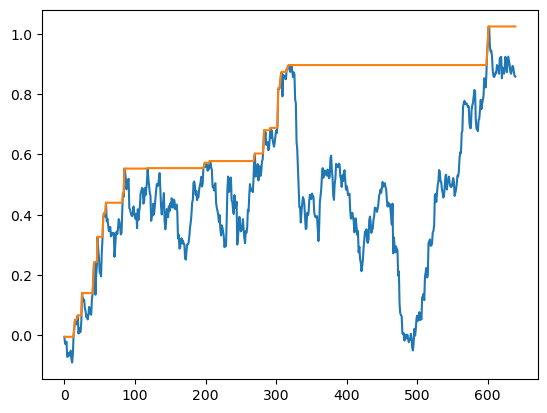

In [118]:
cols = ['index','pred','actual','pnl']
dfpnl = pd.DataFrame(data = pnls, columns=cols)
dfpnl['pred'] = dfpnl['pred'].apply(lambda x: x[0])
print(dfpnl.head())

dfpnl['switch'] = dfpnl['pred'].apply(lambda x  : 1 if x>0 else -1 )
dfpnl['pnl'] = dfpnl['switch'] * dfpnl['actual']
#dfpnl = dfpnl.assign(pnl = lambda r: r['actual'] if r['pred'] > 0   else -1* r['actual'])


for index,row in dfpnl.iterrows():
    row['pred2'] = row['pred']
    wt = 1.0
    if (row['pred']<0):
        wt = -1.0
    dfpnl.loc[index,'pnl'] = wt * dfpnl.loc[index,'actual']

dfpnl['cumpnl'] = dfpnl['pnl'].cumsum()
print(dfpnl.tail())
dfpnl['cummax'] = dfpnl['cumpnl'].cummax()
ret = dfpnl['pnl'].mean()*(252/1.89)
vol = dfpnl['pnl'].std()*pow(252/1.89,0.5)
dfpnl['dd'] = dfpnl['cummax'] - dfpnl['cumpnl']
mdd = dfpnl['dd'].max()
print("Return = ",ret)
print("Vol    = ",vol)
info =0
if(vol>0):
    info = ret/vol
print("Info  = ",info)
calmar=0
if (mdd>0):
    calmar = ret/mdd
print("MDD  = ",mdd)
print("Calmar = ",calmar)
dfpnl['cumpnl'].plot()
dfpnl['cummax'].plot()

In [121]:
dfpnl.to_csv("c://data//transformer_output_" + ticker + ".csv")





